In [1]:
import glob
import warnings
import tarfile
import cv2

import keras
import keras.backend as K

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from keras.layers import BatchNormalization, Activation, Conv2D
from keras.layers import GlobalAveragePooling2D, Lambda
from keras.optimizers import Adam, RMSprop

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical, Sequence
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from keras.models import load_model, model_from_json

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from PIL import Image
from cv2 import resize

import tensorflow as tfw
from keras.applications import ResNet50
from keras import regularizers
import requests
import threading
import random
import time
import urllib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model

from collections import Counter

%matplotlib inline

print('Keras version:', keras.__version__)
# print(os.listdir('SageMaker'))

warnings.simplefilter('default')
!pwd

Using TensorFlow backend.


Keras version: 2.2.4
/home/ec2-user/SageMaker


In [2]:
!pwd

/home/ec2-user/SageMaker


In [3]:
n_cat = 203094
batch_size = 48
batch_size_predict = 128
input_shape = (128,128)

train_path = './landmarks/train/train/'
test_path = './landmarks/test/test/'
train_images = glob.glob(train_path+'*.jpg')
test_images = glob.glob(test_path+'*.jpg')
print(len(train_images))
print(len(test_images))
sample_submission = pd.read_csv('./landmarks/recognition_sample_submission.csv')
sample_submission.shape

4130318
112821


(117703, 2)

In [4]:
train_image_ids = [image_file.replace(
    '.jpg', '').replace(train_path, '') for image_file in train_images]

train_df = pd.DataFrame(index=list(range(0,len(train_image_ids))))
train_df['filename'] = pd.Series(train_images, index=list(range(0,len(train_image_ids))))
train_df['ids'] = train_image_ids
train_df.head()

,filename,ids
0,./landmarks/train/train/2b54de74c01bd09a.jpg,2b54de74c01bd09a
1,./landmarks/train/train/04634b5414f0a90c.jpg,04634b5414f0a90c
2,./landmarks/train/train/6e321a6750ea532c.jpg,6e321a6750ea532c
3,./landmarks/train/train/ccc1ad8d3ef799e7.jpg,ccc1ad8d3ef799e7
4,./landmarks/train/train/d6624b7f6e71de1b.jpg,d6624b7f6e71de1b


In [5]:
test_image_ids = [image_file.replace(
    '.jpg', '').replace(test_path, '') for image_file in test_images]
test_df = pd.DataFrame(index=list(range(0,len(test_image_ids))))
test_df['filename'] = pd.Series(test_images, index=list(range(0,len(test_image_ids))))
test_df['ids'] = test_image_ids
test_df.head()

,filename,ids
0,./landmarks/test/test/fa8d5a81a16f2f2f.jpg,fa8d5a81a16f2f2f
1,./landmarks/test/test/b81a0a45f9b1ee97.jpg,b81a0a45f9b1ee97
2,./landmarks/test/test/570e28cc63fab858.jpg,570e28cc63fab858
3,./landmarks/test/test/b8bc63608b5fef1a.jpg,b8bc63608b5fef1a
4,./landmarks/test/test/54cfd1f5f683b966.jpg,54cfd1f5f683b966


In [101]:
# import train data and test data from 
# https://www.kaggle.com/c/landmark-recognition-2019/discussion/90346#latest-530186
# https://www.kaggle.com/c/landmark-recognition-2019/discussion/91770#latest-530188
# # train
# !wget http://storage.googleapis.com/landmark-recognition-2019/compressed/train-256.tar
# !wget https://storage.googleapis.com/kaggle-forum-message-attachments/521530/13046/test-256.zip

# big shoutout to https://www.kaggle.com/anishagnihotri

In [6]:
def check_size(url):
    r = requests.get(url, stream=True)
    return int(r.headers['Content-Length'])

def download_file(url, filename, bar=True):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    try:
        chunkSize = 1024
        r = requests.get(url, stream=True)
        with open(filename, 'wb') as f:
            if bar:
                pbar = tqdm( unit="B", total=int( r.headers['Content-Length'] ) )
            for chunk in r.iter_content(chunk_size=chunkSize): 
                if chunk: # filter out keep-alive new chunks
                    if bar: 
                        pbar.update (len(chunk))
                    f.write(chunk)
        return filename
    except Exception as e:
        print(e)
        return
    
def download_image_cv2_urllib(url):
    """
    Modifying the url to download the 360p or 720p version actually slows it down. 
    """
    try:
        resp = urllib.request.urlopen(url)
        foo = np.asarray(bytearray(resp.read()), dtype="uint8")
        foo = cv2.imdecode(foo, cv2.IMREAD_COLOR)
        foo = cv2.resize(foo,(128, 128), interpolation=cv2.INTER_AREA)
        return foo
    except:
        return np.array([])
    
# download_file("https://s3.amazonaws.com/google-landmark/metadata/train.csv", "train.csv")

In [7]:
train = pd.read_csv("train.csv",index_col='id')
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))

NUM_THRESHOLD = 250

counts = dict(Counter(train['landmark_id']))
landmarks_dict = {x:[] for x in train.landmark_id.unique() if counts[x] >= NUM_THRESHOLD}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1
    
train['filename'] = pd.Series(train_images, index=train_image_ids)

all_urls = train['url'].tolist()
all_landmarks = train['landmark_id'].tolist()
valid_urls_dict = {x[0].split("/")[-1]:landmark_to_idx[x[1]] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict}
valid_urls_list = [x[0] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict]

NUM_EXAMPLES = len(valid_urls_list)
print("Total number of valid examples: {}".format(NUM_EXAMPLES))


                                                                url  \
id                                                                    
6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

                  landmark_id  
id                             
6e158a47eb2ca3f6       142820  
202cd79556f30760       104169  
3ad87684c99c06e1        37914  
e7f70e9c61e66af3       102140  
4072182eddd0100e         2474  
(4132914, 2)
Number of classes 203094
Total number of valid classes: 1067
Total number of valid examples: 478577


In [8]:
# download_file('https://s3.amazonaws.com/google-landmark/metadata/train_attribution.csv', 'train_attribution.csv')

In [9]:
train_attr = pd.read_csv('train_attribution.csv',index_col='id')
print(train_attr.head())
print(train_attr.shape)
# print("Number of classes {}".format(len(train_attr.landmark.unique())))

# NUM_THRESHOLD = 250

# counts = dict(Counter(train_attr['landmark']))
# landmarks_dict = {x:[] for x in train_attr.landmark_id.unique() if counts[x] >= NUM_THRESHOLD}
# NUM_CLASSES = len(landmarks_dict)
# print("Total number of valid classes: {}".format(NUM_CLASSES))

# i = 0
# landmark_to_idx = {}
# idx_to_landmark = []
# for k in landmarks_dict:
#     landmark_to_idx[k] = i
#     idx_to_landmark.append(k)
#     i += 1
# all_urls = train_attr['url'].tolist()
# all_landmarks = train_attr['landmark_id'].tolist()
# valid_urls_dict = {x[0].split("/")[-1]:landmark_to_idx[x[1]] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict}
# valid_urls_list = [x[0] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict]

# NUM_EXAMPLES = len(valid_urls_list)
# print("Total number of valid examples: {}".format(NUM_EXAMPLES))
# train['filename'] = pd.Series(train_df['filename'],index=train_df['ids'])
# train.head()

                                                                url  \
id                                                                    
6e158a47eb2ca3f6  http://commons.wikimedia.org/wiki/File:Observa...   
202cd79556f30760  http://commons.wikimedia.org/wiki/File:Ecosse2...   
3ad87684c99c06e1  http://commons.wikimedia.org/wiki/File:Pirmase...   
e7f70e9c61e66af3  http://commons.wikimedia.org/wiki/File:Occiden...   
4072182eddd0100e  http://commons.wikimedia.org/wiki/File:Looking...   

                                                     author  \
id                                                            
6e158a47eb2ca3f6                            Holger.Ellgaard   
202cd79556f30760                                 LeCardinal   
3ad87684c99c06e1                                   LoKiLeCh   
e7f70e9c61e66af3                              Andrés Osorio   
4072182eddd0100e  Stephen Whittaker and Katharine Oakeshott   

                                                            

In [10]:
train.head()

,url,landmark_id,filename
id,,,
6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820,./landmarks/train/train/6e158a47eb2ca3f6.jpg
202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169,./landmarks/train/train/202cd79556f30760.jpg
3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914,./landmarks/train/train/3ad87684c99c06e1.jpg
e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140,./landmarks/train/train/e7f70e9c61e66af3.jpg
4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474,./landmarks/train/train/4072182eddd0100e.jpg


In [11]:
train_attr.head()

,url,author,license,title
id,,,,
6e158a47eb2ca3f6,http://commons.wikimedia.org/wiki/File:Observa...,Holger.Ellgaard,CC BY-SA 3.0(http://creativecommons.org/licens...,File:Observatoriet väderkammer 2013a.jpg
202cd79556f30760,http://commons.wikimedia.org/wiki/File:Ecosse2...,LeCardinal,CC-BY-SA-3.0(http://creativecommons.org/licens...,File:Ecosse200996-1.jpg
3ad87684c99c06e1,http://commons.wikimedia.org/wiki/File:Pirmase...,LoKiLeCh,GFDL(http://www.gnu.org/copyleft/fdl.html)/CC-...,File:Pirmasens Dynamikum.jpg
e7f70e9c61e66af3,http://commons.wikimedia.org/wiki/File:Occiden...,Andrés Osorio,CC BY 2.0(http://creativecommons.org/licenses/...,File:Occidental Vertical.jpg
4072182eddd0100e,http://commons.wikimedia.org/wiki/File:Looking...,Stephen Whittaker and Katharine Oakeshott,CC BY-SA 2.0(https://creativecommons.org/licen...,File:Looking downstream from the footbridge ov...


In [12]:
train['landmark_id'].nunique()

203094

In [13]:
train['landmark_id'].values

array([142820, 104169,  37914, ..., 191243, 145760,  34698])

In [14]:
test_info_full = pd.read_csv('test.csv', index_col='id')
test_info_full.head()

test_info = test_info_full.loc[test_image_ids]
test_info['filename'] = pd.Series(test_images, index=test_image_ids)

test_info.head()

,url,filename
id,,
fa8d5a81a16f2f2f,https://lh3.googleusercontent.com/-_SAJTBt3Y64...,./landmarks/test/test/fa8d5a81a16f2f2f.jpg
b81a0a45f9b1ee97,https://lh3.googleusercontent.com/-9sFSIOCzIOs...,./landmarks/test/test/b81a0a45f9b1ee97.jpg
570e28cc63fab858,https://lh3.googleusercontent.com/-7Eld7yUfAB0...,./landmarks/test/test/570e28cc63fab858.jpg
b8bc63608b5fef1a,https://lh3.googleusercontent.com/-JdgzGjeS9NE...,./landmarks/test/test/b8bc63608b5fef1a.jpg
54cfd1f5f683b966,https://lh3.googleusercontent.com/-krCM7YZ3FpU...,./landmarks/test/test/54cfd1f5f683b966.jpg


In [15]:
# !curl https://www.kaggle.com/google/google-landmarks-dataset/downloads/test.csv/29

In [16]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=True, n_values=n_cat)

train['label'] = label_encoder.fit_transform(train['landmark_id'])
train['one_hot'] = one_hot_encoder.fit_transform(
                    train['label'].values.reshape(-1, 1))

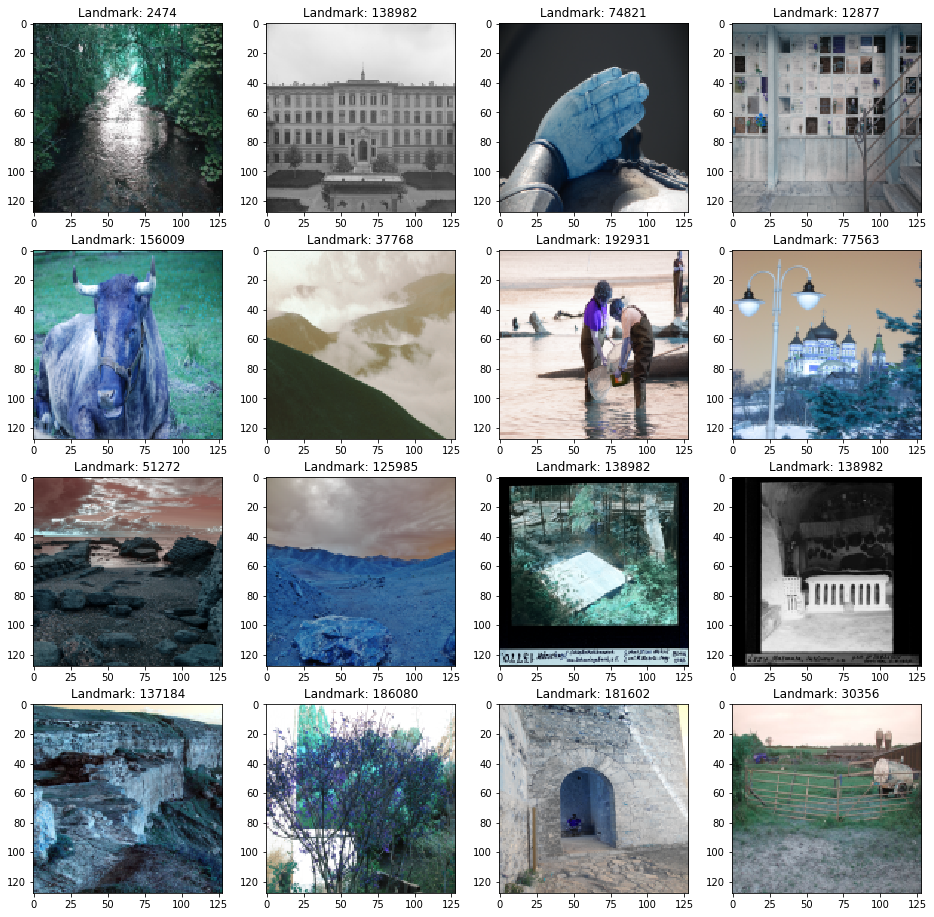

In [21]:
w=20
h=20
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 4
i = 1
for url in valid_urls_list[:16]:
    im = download_image_cv2_urllib(url)
    if im.size != 0:
        fig.add_subplot(rows, columns, i)
        plt.title("Landmark: "+str(idx_to_landmark[valid_urls_dict[url.split("/")[-1]]]))
        plt.imshow(im)
        i += 1

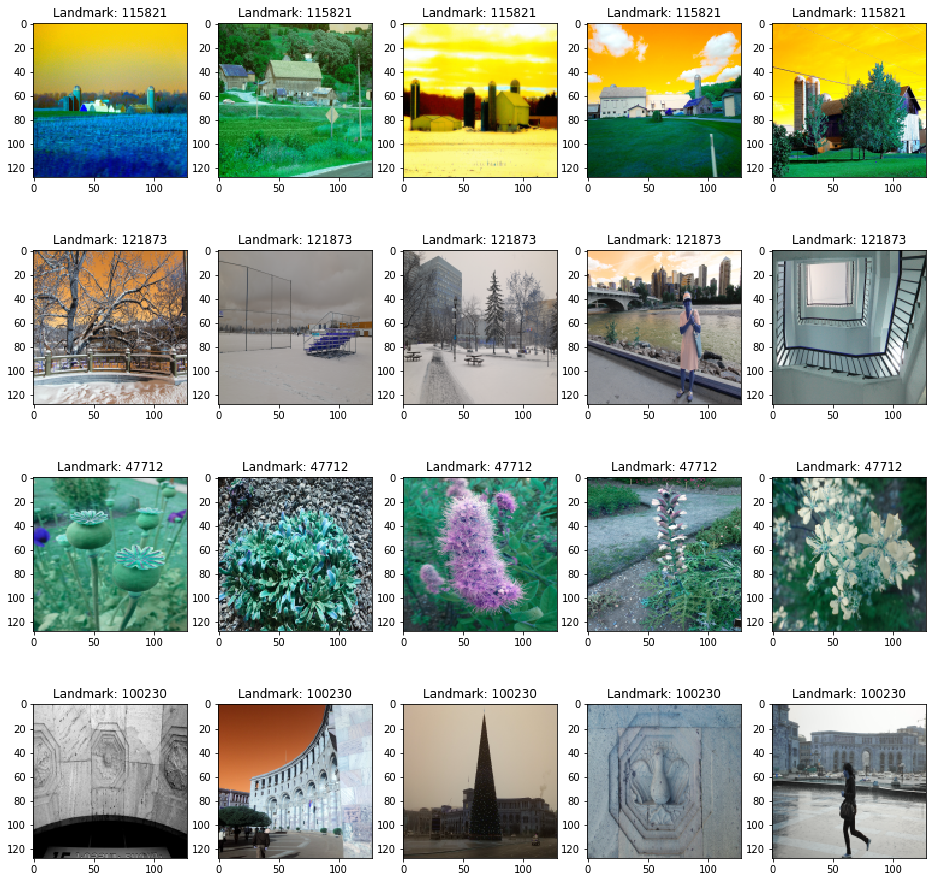

In [22]:
w=20
h=20
fig=plt.figure(figsize=(16, 16))
columns = 5
rows = 4
landmarks = [idx_to_landmark[valid_urls_dict[x]] for x in random.sample(valid_urls_dict.keys(), rows)]
for i in range(rows):
    landmark = landmarks[i]
    urls = [x[0] for x in zip(all_urls, all_landmarks) if x[1]==landmark]
    for j in range(columns):
        im = download_image_cv2_urllib(urls[j])
        if im.size != 0:
            fig.add_subplot(rows, columns, i*columns+j+1)
            plt.title("Landmark: "+str(landmark))
            plt.imshow(im)

In [122]:
train_urls, validation_urls = train_test_split(valid_urls_list, test_size=1.5*NUM_CLASSES/NUM_EXAMPLES)

In [123]:
validation_images = []
validation_y = []
for url in validation_urls:
    im = download_image_cv2_urllib(url)
    if im.size != 0:
        validation_images.append(im)
        validation_y.append(valid_urls_dict[url.split("/")[-1]])

valid_x = np.array(validation_images)
valid_y = np.zeros((len(validation_images), NUM_CLASSES))
        
for i in range(len(validation_y)):
    valid_y[i,validation_y[i]] = 1.

In [17]:
class DataGen(Sequence):
    def __init__(self, data, batch_size=24, verbose=1):
        self.batch_size=batch_size
        self.data_urls = data

    def normalize(self,data):
        return data
    
    def __getitem__(self, index):
        batch_urls = random.sample(self.data_urls, self.batch_size)
        
        output = []
        y_classes = []
        for url in batch_urls:
            im = download_image_cv2_urllib(url)
            if im.size != 0:
                output.append(im)
                y_classes.append(valid_urls_dict[url.split("/")[-1]])
        
        x = np.array(output)
        y = np.zeros((len(output), NUM_CLASSES))
        
        for i in range(len(y_classes)):
            y[i,y_classes[i]] = 1.
        
        return x,y
            
    def on_epoch_end(self):
        return

    def __len__(self):
        #return len(valid_urls_list) // self.batch_size
        return 10

def accuracy_class(y_true, y_pred):
    true = K.argmax(y_true, axis=1)
    pred = K.argmax(y_pred, axis=1)
    matches = K.equal(true, pred)
    return K.mean(matches)


In [127]:
res = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

Instructions for updating:
Colocations handled automatically by placer.
 3661824/94653016 [>.............................] - ETA: 1s

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [128]:
for layer in res.layers[:120]:
    layer.trainable = False

In [129]:
out = Flatten()(res.output)
out = Dense(NUM_CLASSES, activation='softmax')(out)
model = Model(res.input, out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [131]:
optimizer = Adam(0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[accuracy_class])
model.fit_generator(generator=DataGen(train_urls, batch_size=128),
                    validation_data=[valid_x, valid_y],
                    epochs=80,
                    use_multiprocessing=True,
                    workers=8,
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/80
10/10 [==============================] - 139s 14s/step - loss: 0.0092 - accuracy_class: 0.0047 - val_loss: 0.0089 - val_accuracy_class: 0.0131
Epoch 2/80
10/10 [==============================] - 123s 12s/step - loss: 0.0086 - accuracy_class: 0.0321 - val_loss: 0.0084 - val_accuracy_class: 0.0338
Epoch 3/80
10/10 [==============================] - 120s 12s/step - loss: 0.0080 - accuracy_class: 0.0508 - val_loss: 0.0080 - val_accuracy_class: 0.0387
Epoch 4/80
10/10 [==============================] - 129s 13s/step - loss: 0.0076 - accuracy_class: 0.0727 - val_loss: 0.0077 - val_accuracy_class: 0.0450
Epoch 5/80
10/10 [==============================] - 118s 12s/step - loss: 0.0074 - accuracy_class: 0.0750 - val_loss: 0.0074 - val_accuracy_class: 0.0581
Epoch 6/80
10/10 [==============================] - 126s 13s/step - loss: 0.0072 - accuracy_class: 0.0782 - val_loss: 0.0072 - val_accuracy_class: 0.0638
Epoch 7/80
10/10 [==========

10/10 [==============================] - 122s 12s/step - loss: 0.0040 - accuracy_class: 0.3667 - val_loss: 0.0054 - val_accuracy_class: 0.1713
Epoch 53/80
10/10 [==============================] - 119s 12s/step - loss: 0.0040 - accuracy_class: 0.3594 - val_loss: 0.0054 - val_accuracy_class: 0.1638
Epoch 54/80
10/10 [==============================] - 115s 12s/step - loss: 0.0041 - accuracy_class: 0.3758 - val_loss: 0.0054 - val_accuracy_class: 0.1725
Epoch 55/80
10/10 [==============================] - 127s 13s/step - loss: 0.0040 - accuracy_class: 0.3742 - val_loss: 0.0054 - val_accuracy_class: 0.1700
Epoch 56/80
10/10 [==============================] - 114s 11s/step - loss: 0.0039 - accuracy_class: 0.3891 - val_loss: 0.0053 - val_accuracy_class: 0.1731
Epoch 57/80
10/10 [==============================] - 129s 13s/step - loss: 0.0039 - accuracy_class: 0.3722 - val_loss: 0.0053 - val_accuracy_class: 0.1831
Epoch 58/80
10/10 [==============================] - 126s 13s/step - loss: 0.0040 

In [27]:
# model.save_weights('model_weights.h5')
# model.save('resnet50_model.h5')
# model_json = model.to_json()
# with open('model.json', 'w+') as json_file:
#     json_file.write(model_json)

with open('model.json', 'r') as f:
    model = model_from_json(f.read())

model.load_weights('model_weights.h5')

In [35]:
model.layers

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [39]:
os.chdir('Keras-VGG16-places365/')
from vgg16_places_365 import VGG16_Places365
os.chdir('..')

In [18]:
def load_images(info, input_shape = input_shape):
    input_shape = tuple(input_shape)
    imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))

    for i in range(len(info)):
        fname = info.iloc[i]['filename']
        try:
            img = cv2.cvtColor(
                  cv2.resize(cv2.imread(fname),input_shape),
                  cv2.COLOR_BGR2RGB)
        except:
            warnings.warn('Warning: could not read image: '+ fname +
                          '. Use black img instead.')
            img = np.zeros((input_shape[0], input_shape[1], 3))
        imgs[i,:,:,:] = img
    
    return imgs

def load_cropped_images(info, crop_p=0.2, crop='random'):
    new_res = np.array([int(input_shape[0]*(1+crop_p)), int(input_shape[1]*(1+crop_p))])
    if crop == 'random':
        cx0 = np.random.randint(new_res[0] - input_shape[0], size=len(info))
        cy0 = np.random.randint(new_res[1] - input_shape[1], size=len(info))
    else:
        if crop == 'central':
            cx0, cy0 = (new_res - input_shape) // 2                
        if crop == 'upper left':
            cx0, cy0 = 0, 0
        if crop == 'upper right':
            cx0, cy0 = new_res[1] - input_shape[1], 0
        if crop == 'lower left':
            cx0, cy0 = 0, new_res[0] - input_shape[0]
        if crop=='lower right':
            cx0, cy0 = new_res - input_shape        
        cx0 = np.repeat(np.expand_dims(cx0, 0), len(info))
        cy0 = np.repeat(np.expand_dims(cy0, 0), len(info))

    cx1 = cx0 + input_shape[0]
    cy1 = cy0 + input_shape[1]
    
    raw_imgs = load_images(info, input_shape=tuple(new_res))
    
    cropped_imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))
    for ind in range(len(info)):
        cropped_imgs[ind,:,:,:] = raw_imgs[ind,
                                           cy0[ind]:cy1[ind],
                                           cx0[ind]:cx1[ind], :]
    
    return cropped_imgs

def predict(info, load_n_images=1024):
    n = len(info)
    max_p = np.zeros(n)
    pred = np.zeros(n)
    
    for ind in range(0,len(info),load_n_images):
        imgs = load_images(info.iloc[ind:(ind+load_n_images)])
        imgs = preprocess_input(imgs)
        proba = model.predict(imgs, batch_size=batch_size_predict)
        
        pred_i = np.argmax(proba, axis=1)
        max_p[ind:(ind + load_n_images)] = proba[np.arange(len(pred_i)),pred_i]
        pred[ind:(ind + load_n_images)] = label_encoder.inverse_transform(pred_i)
        
        print(ind, '/', len(info), '  -->', pred[ind], max_p[ind])

    print(len(info), '/', len(info), '  -->', pred[-1], max_p[-1])
    
    return pred, max_p

def predict_wcr_vote(info, load_n_images=1024, crop_p=0.1):
    n = len(info)
    max_p = np.zeros(n)
    pred = np.zeros(n)
    
    for ind in range(0,len(info),load_n_images):
        n_crops = 12
        all_proba = np.zeros((n_crops, min(load_n_images, len(info)-ind), n_cat))
        
        imgs = load_images(info.iloc[ind:(ind+load_n_images)])
        imgs = preprocess_input(imgs)
        
        #full image
        all_proba[0,:,:] = model.predict(imgs, batch_size=batch_size_predict)
        all_proba[1,:,:] = model.predict(np.flip(imgs, axis=2), 
                                         batch_size=batch_size_predict)
        
        crops = ['upper left', 'lower left', 'upper right', 'lower right', 'central']
        jnd_0 = 2
        for jnd,crop in enumerate(crops):
            imgs = load_cropped_images(info.iloc[ind:(ind+load_n_images)], 
                                  crop_p=crop_p, crop=crop)  # optimize later
            imgs = preprocess_input(imgs)
            all_proba[jnd_0+2*jnd,:,:] = model.predict(imgs, 
                                                       batch_size=batch_size_predict)
            all_proba[jnd_0+2*jnd+1,:,:] = model.predict(np.flip(imgs, axis=2), 
                                                         batch_size=batch_size_predict)
        
        cmax_p = np.zeros((n_crops,imgs.shape[0]))
        cpred = np.zeros((n_crops,imgs.shape[0]))
        for jnd in range(all_proba.shape[0]):
            proba = all_proba[jnd,:,:]
            pred_i = np.argmax(proba, axis=1)
            cmax_p[jnd,:] = proba[np.arange(len(pred_i)),pred_i]
            cpred[jnd,:] = label_encoder.inverse_transform(pred_i)
        
        for knd in range(imgs.shape[0]):
            c_res = pd.DataFrame({'max_cat':cpred[:,knd], 'max_p':cmax_p[:,knd]})
            c_res = c_res.groupby('max_cat').aggregate('sum') / n_crops
            pred[ind + knd]=c_res['max_p'].idxmax()
            max_p[ind + knd]=c_res.loc[pred[ind + knd]]['max_p']
                  
        print(ind,'/',len(info), '  -->', pred[ind], max_p[ind])
    print(len(info),'/',len(info), '  -->', pred[-1], max_p[-1])
    
    return pred, max_p

def validate(info, load_n_images=1024, wcr=False, crop_p=0.1):
    if wcr:
        pred, max_p = predict_wcr_vote(info, load_n_images=load_n_images, crop_p=crop_p)
    else:
        pred, max_p = predict(info, load_n_images=load_n_images)
    
    y = info['landmark_id'].values
    binary_acc = accuracy_score(y, pred)

    sort_ind = np.argsort(max_p)[::-1]

    pred = pred[sort_ind]
    y_true = y[sort_ind]

    GAP = np.sum(np.cumsum(pred == y_true)
                 * (pred == y_true) 
                 / np.arange(1, len(y_true) + 1)) / np.sum(y_true >= 0.)

    print("accuracy:", binary_acc, "\n ")
    print("*** GAP:", GAP, "***")
    
    return binary_acc, GAP

In [19]:
def get_custom_loss(rank_weight=1., epsilon=1.e-9):
    def custom_loss(y_t, y_p):
        losses = tfw.reduce_sum(-y_t*tfw.log(y_p+epsilon) - (1.-y_t)*tfw.log(1.-y_p+epsilon), 
                               axis=-1)
        
        pred_idx = tfw.argmax(y_p, axis=-1)
        
        mask = tfw.one_hot(pred_idx, 
                          depth=y_p.shape[1], 
                          dtype=tfw.bool, 
                          on_value=True, 
                          off_value=False)
        pred_cat = tfw.boolean_mask(y_p, mask)
        y_t_cat = tfw.boolean_mask(y_t, mask)
        
        n_pred = tfw.shape(pred_cat)[0]
        _, ranks = tfw.nn.top_k(pred_cat, k=n_pred)
        
        ranks = tfw.cast(n_pred-ranks, tfw.float32)/tfw.cast(n_pred, tfw.float32)*rank_weight
        rank_losses = ranks*(-y_t_cat*tfw.log(pred_cat+epsilon)
                             -(1.-y_t_cat)*tfw.log(1.-pred_cat+epsilon))        
        
        return rank_losses + losses
    return custom_loss

def batch_GAP(y_t, y_p):
    pred_cat = tfw.argmax(y_p, axis=-1)    
    y_t_cat = tfw.argmax(y_t, axis=-1) * tfw.cast(
        tfw.reduce_sum(y_t, axis=-1), tfw.int64)
    
    n_pred = tfw.shape(pred_cat)[0]
    is_c = tfw.cast(tfw.equal(pred_cat, y_t_cat), tfw.float32)

    GAP = tfw.reduce_mean(
          tfw.cumsum(is_c) * is_c / tfw.cast(
              tfw.range(1, n_pred + 1), 
              dtype=tfw.float32))
    
    return GAP

def binary_crossentropy_n_cat(y_t, y_p):
    return keras.metrics.binary_crossentropy(y_t, y_p) * n_cat


In [20]:
#clear

K.clear_session()

In [21]:
def get_image_gen(info_arg, 
                  shuffle=True, 
                  image_aug=True, 
                  eq_dist=False, 
                  n_ref_imgs=16, 
                  crop_prob=0.5, 
                  crop_p=0.5):
    if image_aug:
        datagen = ImageDataGenerator(
            rotation_range=4.,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.5,
            channel_shift_range=25,
            horizontal_flip=True,
            fill_mode='nearest')
        
        if crop_prob > 0:
            datagen_crop = ImageDataGenerator(
                rotation_range=4.,
                shear_range=0.2,
                zoom_range=0.1,
                channel_shift_range=20,
                horizontal_flip=True,
                fill_mode='nearest')
        
    count = len(info_arg)
    while True:
        if eq_dist:
            def sample(df):
                return df.sample(min(n_ref_imgs, len(df)))
            info = info_arg.groupby('landmark_id', group_keys=False).apply(sample)
        else:
            info = info_arg
        print('Generate', len(info), 'for the next round.')
        
        #shuffle data
        if shuffle and count >= len(info):
            info = info.sample(frac=1)
            count = 0
            
        # load images
        for ind in range(0,len(info), batch_size):
            count += batch_size

            y = info['landmark_id'].values[ind:(ind+batch_size)]
            
            if np.random.rand() < crop_prob:
                imgs = load_cropped_images(info.iloc[ind:(ind+batch_size)], 
                                           crop_p=crop_p*np.random.rand() + 0.01, 
                                           crop='random')
                if image_aug:
                    cflow = datagen_crop.flow(imgs, 
                                              y, 
                                              batch_size=imgs.shape[0], 
                                              shuffle=False)
                    imgs, y = next(cflow)                    
            else:
                imgs = load_images(info.iloc[ind:(ind+batch_size)])
                if image_aug:
                    cflow = datagen.flow(imgs, 
                                       y, 
                                       batch_size=imgs.shape[0], 
                                       shuffle=False)
                    imgs, y = next(cflow)             

            imgs = preprocess_input(imgs)
    
            y_l = label_encoder.transform(y[y>=0.])        
            y_oh = np.zeros((len(y), n_cat))
            y_oh[y >= 0., :] = one_hot_encoder.transform(y_l.reshape(-1,1)).todense()
                    
            yield imgs, y_oh
            
train_gen = get_image_gen(train, 
                          eq_dist=False, 
                          n_ref_imgs=256, 
                          crop_prob=0.5, 
                          crop_p=0.5)


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:


Generate 4132914 for the next round.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


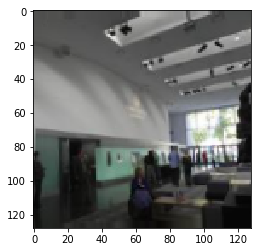

In [22]:
X_example, y_example = next(train_gen)
plt.imshow(X_example[1,:,:,:]/2. + 0.5)

In [23]:
list(input_shape) + [3]

[128, 128, 3]

In [24]:
K.clear_session()

In [25]:
x_model = Xception(input_shape=(128,128,3), 
                   weights='imagenet', 
                   include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
x_model.summary()
print((x_model.layers[85]).name)
print((x_model.layers[25]).name)
print((x_model.layers[15]).name)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [27]:
x_model.output_shape[1:]

(4, 4, 2048)

In [28]:
gm_exp = tfw.Variable(3., dtype=tfw.float32)
def generalized_mean_pool_2d(X):
    pool = (tfw.reduce_mean(tfw.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool


In [29]:
for layer in x_model.layers:
    layer.trainable = True
for layer in x_model.layers[:85]:
    layer.trainable = False
    
X_feat = Input(x_model.output_shape[1:])

lambda_layer = Lambda(generalized_mean_pool_2d)
lambda_layer.trainable_weights.extend([gm_exp])
X = lambda_layer(X_feat)
X = Dropout(0.05)(X)
X = Activation('relu')(X)
X = Dense(n_cat, activation='softmax')(X)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [30]:
top_model = Model(inputs=X_feat, outputs=X)
top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 4, 2048)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2048)              1         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
activation_1 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 203094)            416139606 
Total params: 416,139,607
Trainable params: 416,139,607
Non-trainable params: 0
_________________________________________________________________


In [31]:
X_image = Input(list(input_shape) + [3])

X_f = x_model(X_image)
X_f = top_model(X_f)

model = Model(inputs=X_image, outputs=X_f)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
model_1 (Model)              (None, 203094)            416139607 
Total params: 437,001,087
Trainable params: 427,769,919
Non-trainable params: 9,231,168
_________________________________________________________________


In [32]:
opt = Adam(lr=0.0001)
loss = get_custom_loss(1.0)
#loss='categorical_crossentropy'
#loss='binary_crossentropy'
model = multi_gpu_model(model, gpus=8)
model.compile(loss=loss, 
              optimizer=opt, 
              metrics=[binary_crossentropy_n_cat, 'accuracy', batch_GAP])

In [33]:
checkpoint1 = ModelCheckpoint('dd_checkpoint-1.h5', 
                              period=1, 
                              verbose=1, 
                              save_weights_only=True)
checkpoint2 = ModelCheckpoint('dd_checkpoint-2.h5', 
                              period=1, 
                              verbose=1, 
                              save_weights_only=True)
checkpoint3 = ModelCheckpoint('dd_checkpoint-3-best.h5', 
                              period=1, 
                              verbose=1, 
                              monitor='loss', 
                              save_best_only=True, 
                              save_weights_only=True)

In [34]:
K.set_value(model.optimizer.lr, 0.0000003)

In [35]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1',
 '/job:localhost/replica:0/task:0/device:GPU:2',
 '/job:localhost/replica:0/task:0/device:GPU:3',
 '/job:localhost/replica:0/task:0/device:GPU:4',
 '/job:localhost/replica:0/task:0/device:GPU:5',
 '/job:localhost/replica:0/task:0/device:GPU:6',
 '/job:localhost/replica:0/task:0/device:GPU:7']

In [36]:
def load_images(info, input_shape = input_shape):
    input_shape = tuple(input_shape)
    imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))

    for i in range(len(info)):
        fname = info.iloc[i]['filename']
        try:
            img = cv2.cvtColor(
                  cv2.resize(cv2.imread(fname),input_shape),
                  cv2.COLOR_BGR2RGB)
        except:
            warnings.warn('Warning: could not read image: '+ fname +
                          '. Use black img instead.')
            img = np.zeros((input_shape[0], input_shape[1], 3))
        imgs[i,:,:,:] = img
    
    return imgs

def load_cropped_images(info, crop_p=0.2, crop='random'):
    new_res = np.array([int(input_shape[0]*(1+crop_p)), int(input_shape[1]*(1+crop_p))])
    if crop == 'random':
        cx0 = np.random.randint(new_res[0] - input_shape[0], size=len(info))
        cy0 = np.random.randint(new_res[1] - input_shape[1], size=len(info))
    else:
        if crop == 'central':
            cx0, cy0 = (new_res - input_shape) // 2                
        if crop == 'upper left':
            cx0, cy0 = 0, 0
        if crop == 'upper right':
            cx0, cy0 = new_res[1] - input_shape[1], 0
        if crop == 'lower left':
            cx0, cy0 = 0, new_res[0] - input_shape[0]
        if crop=='lower right':
            cx0, cy0 = new_res - input_shape        
        cx0 = np.repeat(np.expand_dims(cx0, 0), len(info))
        cy0 = np.repeat(np.expand_dims(cy0, 0), len(info))

    cx1 = cx0 + input_shape[0]
    cy1 = cy0 + input_shape[1]
    
    raw_imgs = load_images(info, input_shape=tuple(new_res))
    
    cropped_imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))
    for ind in range(len(info)):
        cropped_imgs[ind,:,:,:] = raw_imgs[ind,
                                           cy0[ind]:cy1[ind],
                                           cx0[ind]:cx1[ind], :]
    
    return cropped_imgs

def predict(info, load_n_images=1024):
    n = len(info)
    max_p = np.zeros(n)
    pred = np.zeros(n)
    
    for ind in range(0,len(info),load_n_images):
        imgs = load_images(info.iloc[ind:(ind+load_n_images)])
        imgs = preprocess_input(imgs)
        proba = model.predict(imgs, batch_size=batch_size_predict)
        
        pred_i = np.argmax(proba, axis=1)
        max_p[ind:(ind + load_n_images)] = proba[np.arange(len(pred_i)),pred_i]
        pred[ind:(ind + load_n_images)] = label_encoder.inverse_transform(pred_i)
        
        print(ind, '/', len(info), '  -->', pred[ind], max_p[ind])

    print(len(info), '/', len(info), '  -->', pred[-1], max_p[-1])
    
    return pred, max_p

def predict_wcr_vote(info, load_n_images=1024, crop_p=0.1):
    n = len(info)
    max_p = np.zeros(n)
    pred = np.zeros(n)
    
    for ind in range(0,len(info),load_n_images):
        n_crops = 12
        all_proba = np.zeros((n_crops, min(load_n_images, len(info)-ind), n_cat))
        
        imgs = load_images(info.iloc[ind:(ind+load_n_images)])
        imgs = preprocess_input(imgs)
        
        #full image
        all_proba[0,:,:] = model.predict(imgs, batch_size=batch_size_predict)
        all_proba[1,:,:] = model.predict(np.flip(imgs, axis=2), 
                                         batch_size=batch_size_predict)
        
        crops = ['upper left', 'lower left', 'upper right', 'lower right', 'central']
        jnd_0 = 2
        for jnd,crop in enumerate(crops):
            imgs = load_cropped_images(info.iloc[ind:(ind+load_n_images)], 
                                  crop_p=crop_p, crop=crop)  # optimize later
            imgs = preprocess_input(imgs)
            all_proba[jnd_0+2*jnd,:,:] = model.predict(imgs, 
                                                       batch_size=batch_size_predict)
            all_proba[jnd_0+2*jnd+1,:,:] = model.predict(np.flip(imgs, axis=2), 
                                                         batch_size=batch_size_predict)
        
        cmax_p = np.zeros((n_crops,imgs.shape[0]))
        cpred = np.zeros((n_crops,imgs.shape[0]))
        for jnd in range(all_proba.shape[0]):
            proba = all_proba[jnd,:,:]
            pred_i = np.argmax(proba, axis=1)
            cmax_p[jnd,:] = proba[np.arange(len(pred_i)),pred_i]
            cpred[jnd,:] = label_encoder.inverse_transform(pred_i)
        
        for knd in range(imgs.shape[0]):
            c_res = pd.DataFrame({'max_cat':cpred[:,knd], 'max_p':cmax_p[:,knd]})
            c_res = c_res.groupby('max_cat').aggregate('sum') / n_crops
            pred[ind + knd]=c_res['max_p'].idxmax()
            max_p[ind + knd]=c_res.loc[pred[ind + knd]]['max_p']
                  
        print(ind,'/',len(info), '  -->', pred[ind], max_p[ind])
    print(len(info),'/',len(info), '  -->', pred[-1], max_p[-1])
    
    return pred, max_p

def validate(info, load_n_images=1024, wcr=False, crop_p=0.1):
    if wcr:
        pred, max_p = predict_wcr_vote(info, load_n_images=load_n_images, crop_p=crop_p)
    else:
        pred, max_p = predict(info, load_n_images=load_n_images)
    
    y = info['landmark_id'].values
    binary_acc = accuracy_score(y, pred)

    sort_ind = np.argsort(max_p)[::-1]

    pred = pred[sort_ind]
    y_true = y[sort_ind]

    GAP = np.sum(np.cumsum(pred == y_true)
                 * (pred == y_true) 
                 / np.arange(1, len(y_true) + 1)) / np.sum(y_true >= 0.)

    print("accuracy:", binary_acc, "\n ")
    print("*** GAP:", GAP, "***")
    
    return binary_acc, GAP

In [39]:
model._make_predict_function

<bound method Model._make_predict_function of <keras.engine.training.Model object at 0x7f52decf22e8>>

In [40]:
batch_size = 128

model.fit_generator(train_gen, 
                    steps_per_epoch=len(train) / batch_size / 8, 
                    epochs=50, 
                    callbacks=[checkpoint1, checkpoint2, checkpoint3])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/50


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


ResourceExhaustedError: OOM when allocating tensor with shape[128,203094] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node loss/model_1_loss/mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node training/Adam/gradients/model_1_1/concat_grad/Slice_5}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [32]:
# print(model.history.history['loss'])
# plt.plot(model.history.history['loss'])
# plt.xlabel('epoch')
# plt.ylabel('loss')

In [33]:
# model.history.history.keys()

In [34]:
# plt.plot(model.history.history['accuracy_class'])
# plt.xlabel('epoch')
# plt.ylabel('accuracy_class')

In [ ]:
test_pred, test_max_p = predict_wcr_vote(test_info, 512, crop_p=0.1)


In [84]:
# !kaggle competitions download -c landmark-recognition-2019

In [85]:
# !unzip recognition_sample_submission.csv.zip

./                           fastai/                 landmarks/    tf_36.ipynb
../                          .ipynb_checkpoints/     lost+found/
conda_pytorch_36_good.ipynb  Keras-VGG16-places365/  .sparkmagic/
